Analysis of E2E dataset with shuffled labeled dataset (fake and non fake reviews). The aim of this task is to generate a CNN model to classify sentences on the basis of the semantic similarity.



In [1]:
# import libraries
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# to update later
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.metrics import f1_score
from pandas.tools.plotting import scatter_matrix

seed = 10

warnings.filterwarnings('ignore')

Dataset already labeled and shuffled.

In [4]:
data_path = pd.read_csv('data/dataframe.csv')

data = data_path.drop(data_path.columns[0], axis=1)
data

,label,mr,ref
0,1,name cocum eattype coffee shop food englis...,cocum cheap chinese coffee shop family friendl...
1,0,name the eagle customer rating 5 out of 5 ...,eagle city centre near café brazil family frie...
2,0,name cotto eattype coffee shop food englis...,area riverside near portland arms cotto high p...
3,1,name the wrestlers eattype coffee shop foo...,wrestlers family friendly venue near sorrento ...
4,1,name the punter customer rating average ar...,punter family friendly place riverside area hi...
5,0,name the phoenix customer rating 5 out of 5 ...,5 5 rated phoenix located riverside area
6,1,name the eagle eattype coffee shop food en...,eagle coffee shop eat chinese food cheaply fam...
7,1,name cocum eattype coffee shop food chines...,cocum family friendly coffee shop serves chine...
8,1,name the wrestlers eattype coffee shop foo...,wrestlers coffee shop located riverside near r...
9,0,name fitzbillies eattype coffee shop food ...,fitzbillies adult themed coffee shop located c...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9344 entries, 0 to 9343
Data columns (total 3 columns):
label    9344 non-null int64
mr       9344 non-null object
ref      9344 non-null object
dtypes: int64(1), object(2)
memory usage: 219.1+ KB


The dataset has 9344 entries with the following data:
1-'mr' : Meaning representation
2-'ref' string containing the values in 'mr'
3-label: 0 for non fake and 1 for fake reviews.

In [6]:
import numpy as np
import keras.backend as K
import string
from nltk.corpus import stopwords
import re
from numpy.linalg import norm
import csv

stop_words = stopwords.words('english')


def reshape_data(mr_data, ref_data, y_data):
    '''
    Reshapes the input data.
    :param mr_data: mr
    :param ref_data: ref
    :param y_data: output
    :return: a reshaped mr, ref, output
    '''
    # mr
    mr = np.array(mr_data)
    mr = mr.reshape(mr.shape +  (1, ))
    
    # ref
    ref = np.array(ref_data)
    ref = ref.reshape(ref.shape + (1,))
    
    # y
    y = np.array(y_data)
    y  = y.reshape((y.shape[0], 1))
    
    return mr, ref, y



def clean_str(txt):
    '''
    Cleans a text by removing all non alphanumeric characters.
    :param txt: String, the input sentence.
    :return: A cleaned sentence.
    '''
    txt = str(txt)
    txt = re.sub(r"[^A-Za-z0-9(),!?\'\`&%]", " ", txt)
    txt = re.sub(r"\'s", " \'s", txt)
    txt = re.sub(r"\'ve", " \'ve", txt)
    txt = re.sub(r"\'t", " n\'t", txt)
    txt = re.sub(r"\'re", " \'re", txt)
    txt = re.sub(r"\'d", " \'d", txt)
    txt = re.sub(r"\'ll", " \'ll", txt)
    txt = re.sub(r",", " , ", txt)
    txt = re.sub(r"!", " ! ", txt)
    txt = re.sub(r"\(", " ( ", txt)
    txt = re.sub(r"\)", " ) ", txt)
    txt = re.sub(r"\?", " ? ", txt)
    txt = re.sub(r"\&", " & ", txt)
    txt = re.sub(r"\%", " percent ", txt)
    txt = txt.strip().lower()
    return txt

def remove_punctuation(txt):
    '''
    Removes punctuations in a given sentence.
    :param txt: String, input sentence.
    :return: a list of words from the input sentence without punctuation.
    '''
    return [w for w in txt if w not in string.punctuation]


def remove_stopwords(txt):
    '''
    Removes english stopword in a given sentence.
    :param txt: String, the input sentence.
    :return: A list of words from the input sentence without any stopwords.
    '''
    return [w for w in txt if w not in stop_words]



def fbeta(y_true, y_pred, threshold_shift=0, beta=1):
    '''
    Compute fbeta score.
    :param y_true: y_true
    :param y_pred: predicted value
    :param threshold_shift: threshold
    :param beta: beta value
    :return: fbeta score
    '''
    
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
    y_true = K.clip(y_true, 0, 1)
    
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
    
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())




def cosine_sim(u, v):
    '''
    Computes the cosine similarity between two vectors u and v.
    :param u: Numpy ndarray, the vector u.
    :param v: Numpy ndarray, the vector v.
    :return: Float between 0 and 1, the cosine similarity score between the vector u and v.
    '''
    return np.dot(u,v) / (norm(u)*norm(v))


def similarity(q1, q2):
    '''
    Computes the similarity score between lists of vectors.
    :param q1: List of the first vector.
    :param q2: List of the second vector.
    :return: A list of similarity score between vectors in q1 and q2.
    '''
    sim = []
    for el1, el2 in zip(q1, q2):
        sim.append(cosine_sim(el1, el2))

    return sim

def save_result(filename, results):
    '''
    Saves a dictionary of data into a file.
    :param filename: String, the filename
    :param results: The dictionary to save into the file
    '''
    keys = results[0].keys()
    with open(filename, 'w') as f:
        dict_writer = csv.DictWriter(f,  keys)
        dict_writer.writeheader()
        dict_writer.writerows(results)

def make_accuracy(threshold_shift):
    '''
    Creates an accuracy function with a given threshold.
    :param threshold_shift: Float, threshold
    :return: An accuracy function
    '''
    def accuracy(y_true, y_pred):
        '''
        Compute accuracy score
        :param y_true: actual output
        :param y_pred: predicted output
        :return: accuracy score
        '''
        y_pred = K.clip(y_pred, 0, 1)
        y_pred = K.round(y_pred + threshold_shift)
        return K.mean(K.equal(y_true, y_pred))
    return accuracy
    

def make_fbeta(threshold_shift):
    '''
    Creates fbeta function with a given threshold.
    :param threshold_shift: Float, threshold shift
    :return: An fbeta function
    '''
    def fbeta(y_true, y_pred, beta=1):
        '''
        Computes the fbeta score.
        :param y_true: y_true
        :param y_pred: predicted value
        :param beta: beta value.
        :return: fbeta score.
        '''
        # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)
        y_true = K.clip(y_true, 0, 1)
        
        # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred + threshold_shift)
        
        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    
    return fbeta

def get_w2v_vector(model, sentence, vector_size):
    '''
    Get the word2vec vector of a given sentence.
    :param model: word2vec model
    :param sentence: sentence
    :param vector_size: vector size
    :return: a word2vec vector of a given sentence
    '''
    sentence_len = len(sentence)
    sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
    for i in range(sentence_len):
        word = sentence[i]
        word_vector = model[word]
        sentence2vec[i] = word_vector
    return sentence2vec

Using TensorFlow backend.


In [7]:

# Remove all non-alphanumeric token in our corpus
data['mr'] = data['mr'].apply(clean_str)
data['ref'] = data['ref'].apply(clean_str)

In [8]:
data.head()

,label,mr,ref
0,1,name cocum eattype coffee shop food englis...,cocum cheap chinese coffee shop family friendl...
1,0,name the eagle customer rating 5 out of 5 ...,eagle city centre near caf brazil family frie...
2,0,name cotto eattype coffee shop food englis...,area riverside near portland arms cotto high p...
3,1,name the wrestlers eattype coffee shop foo...,wrestlers family friendly venue near sorrento ...
4,1,name the punter customer rating average ar...,punter family friendly place riverside area hi...


In [9]:
elt = data.mr.append(data.ref)

In [10]:
for i in range(5):
    print("mr: {0}".format(data['mr'][i]))
    print("ref: {0}".format(data['ref'][i]))
    if data['label'][i] == 0:
        print("is not fake")
    else:
        print("is fake")
        
    print()

mr: name cocum   eattype coffee shop   food english   pricerange  20 25   customer rating high   familyfriendly yes
ref: cocum cheap chinese coffee shop family friendly average customer rating
is fake

mr: name the eagle   customer rating 5 out of 5   area city centre   familyfriendly no   near caf  brazil
ref: eagle city centre near caf  brazil family friendly rating 5 5
is not fake

mr: name cotto   eattype coffee shop   food english   pricerange high   customer rating 1 out of 5   area riverside   near the portland arms
ref: area riverside near portland arms cotto high priced coffee shop english food 1 5 customer rating
is not fake

mr: name the wrestlers   eattype coffee shop   food english   pricerange more than  30   area riverside   familyfriendly yes   near raja indian cuisine
ref: wrestlers family friendly venue near sorrento low customer ratings
is fake

mr: name the punter   customer rating average   area city centre   familyfriendly no
ref: punter family friendly place rive

In [11]:

d = data.groupby(['label'])[['mr']].count()

In [12]:
d

,mr
label,
0,4672
1,4672


In [13]:
d['mr']/data.shape[0] * 200


label
0    100.0
1    100.0
Name: mr, dtype: float64

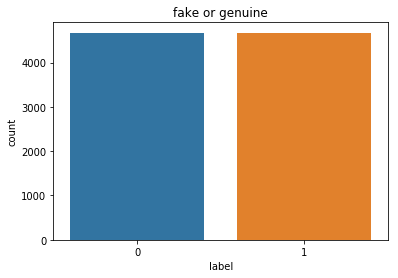

In [14]:

sns.countplot(x='label', data=data)
plt.title('fake or genuine')
plt.show()

In [15]:
data['mr'] = data['mr'].apply(lambda x: x.split())
data['ref'] = data['ref'].apply(lambda x: x.split())

In [16]:

data['mr_len'] = data['mr'].apply(len)
data['ref_len'] = data['ref'].apply(len)

In [17]:

data.head()

,label,mr,ref,mr_len,ref_len
0,1,"[name, cocum, eattype, coffee, shop, food, eng...","[cocum, cheap, chinese, coffee, shop, family, ...",15,10
1,0,"[name, the, eagle, customer, rating, 5, out, o...","[eagle, city, centre, near, caf, brazil, famil...",17,11
2,0,"[name, cotto, eattype, coffee, shop, food, eng...","[area, riverside, near, portland, arms, cotto,...",21,16
3,1,"[name, the, wrestlers, eattype, coffee, shop, ...","[wrestlers, family, friendly, venue, near, sor...",20,9
4,1,"[name, the, punter, customer, rating, average,...","[punter, family, friendly, place, riverside, a...",11,11


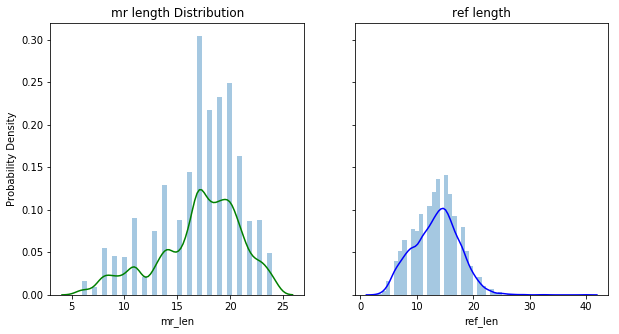

In [18]:

# what is the age distribution?
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.distplot(data['mr_len'],kde_kws={'color': 'green'}, ax=axs[0], label='mr');
axs[0].set(title='mr length Distribution')
axs[0].set(ylabel='Probability Density')
sns.distplot(data['ref_len'], kde_kws={'color': 'blue'}, ax=axs[1], label='ref' );
axs[1].set(title='ref length')
plt.show()

In [19]:
data.drop(['mr_len', 'ref_len'], axis=1, inplace=True)

In [20]:
data.shape

(9344, 3)

In [21]:
data_cnn = data.copy()

In [22]:
data_cnn.head()

,label,mr,ref
0,1,"[name, cocum, eattype, coffee, shop, food, eng...","[cocum, cheap, chinese, coffee, shop, family, ..."
1,0,"[name, the, eagle, customer, rating, 5, out, o...","[eagle, city, centre, near, caf, brazil, famil..."
2,0,"[name, cotto, eattype, coffee, shop, food, eng...","[area, riverside, near, portland, arms, cotto,..."
3,1,"[name, the, wrestlers, eattype, coffee, shop, ...","[wrestlers, family, friendly, venue, near, sor..."
4,1,"[name, the, punter, customer, rating, average,...","[punter, family, friendly, place, riverside, a..."


In [23]:
# take only the first words 
data_cnn['mr'] = data_cnn['mr'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])
data_cnn['ref'] = data_cnn['ref'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])

In [24]:
data_cnn.head()

,label,mr,ref
0,1,"[name, cocum, eattype, coffee, shop, food, eng...","[cocum, cheap, chinese, coffee, shop, family, ..."
1,0,"[name, the, eagle, customer, rating, 5, out, o...","[eagle, city, centre, near, caf, brazil, famil..."
2,0,"[name, cotto, eattype, coffee, shop, food, eng...","[area, riverside, near, portland, arms, cotto,..."
3,1,"[name, the, wrestlers, eattype, coffee, shop, ...","[wrestlers, family, friendly, venue, near, sor..."
4,1,"[name, the, punter, customer, rating, average,...","[punter, family, friendly, place, riverside, a..."


In [25]:
# get all the questions
questions = data_cnn['mr'].append(data_cnn['ref'], ignore_index=True).tolist()

In [26]:
import multiprocessing
# build word2vec model using only 200 features
num_features = 200
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 5
downsampling = 1e-3
seed = 10
sg=1

In [27]:
import gensim.models.word2vec as w2v
import multiprocessing
import numpy as np

FILENAME = 'models/model.w2v'
class Word2VecModel(object):
    '''In domain word embeddings model using word2vec algorithm'''
    def __init__(self):
        self._model = None
        self.filename = FILENAME
        
    @classmethod
    def from_file(cls, filename):
        self = cls()
        self._model = w2v.Word2Vec.load(filename)
        self.filename = filename
        return self
        
    def create_w2v_model(self, sentences, num_features, min_word, context,
                         sg, downsampling, seed):
        '''
        Builds the word2vec model from a corpus of text.
        :param sentences: List of list of string, the corpus.
        :param num_features: Integer, embedding length.
        :param min_word: Integer, the algorithm will ignore all word with frequency lower than min_word.
        :param context: Integer, window size, the maximum distance between the current and predicted word within the sentence.
        :param sg: Integer - 0 or 1 -, which indicates whether to use the skip-gram archittecture (1), or the continuous bag of words archittecture (0).
        :param downsampling: Threshold for configuring which higher-frequency words are randomly downsampled;
        :param seed: Integer, a random seed.
        :return: the word2vec model
        '''
    
        # define parameters
        num_features = num_features
        min_word_count = min_word
        num_workers = multiprocessing.cpu_count()
        context = context
        downsampling = downsampling
    
        # create model
        model = w2v.Word2Vec(sg=sg, seed=seed,  workers=num_workers, \
                             size=num_features, min_count=min_word_count, \
                             window=context, sample=downsampling )
    
        model.build_vocab(sentences)
        model.train(sentences, total_examples=model.corpus_count, epochs=model.iter )
        self._model = model
        model.save(self.filename)

    def get_w2v_vector(self, sentence, vector_size):
        '''
        Gets the word representations of a given sentence.
        :param sentence: List of string, the input sentence.
        :param vector_size: Integer, embedding size.
        :return: A list of word representations.
        '''
    
        sentence_len = len(sentence)
        sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
        for i in range(sentence_len):
            word = sentence[i]
            word_vector = self._model[word]
            sentence2vec[i] = word_vector
    
        return sentence2vec

In [28]:
model = Word2VecModel()
model.create_w2v_model(questions, num_features, min_word_count, context_size,
                         sg, downsampling, seed)

In [29]:
def get_w2v_vector(self, sentence, vector_size):
        '''
        Gets the word representations of a given sentence.
        :param sentence: List of string, the input sentence.
        :param vector_size: Integer, embedding size.
        :return: A list of word representations.
        '''
    
        sentence_len = len(sentence)
        sentence2vec = np.zeros(shape=(sentence_len, vector_size), dtype='float32')
        for i in range(sentence_len):
            word = sentence[i]
            word_vector = self._model[word]
            sentence2vec[i] = word_vector
    
        return sentence2vec

In [30]:
data_cnn['mr'] = data_cnn['mr'].apply(lambda x: get_w2v_vector(model, x, vector_size=200))
data_cnn['ref'] = data_cnn['ref'].apply(lambda x: get_w2v_vector(model, x, vector_size=200))

In [31]:
# get the shape
data_cnn.shape

(9344, 3)

In [32]:
# split a data into fake and not fake
data_fake = data_cnn[data_cnn['label'] == 1]
data_nonfake = data_cnn[data_cnn['label'] == 0]

In [33]:
# get the number of fake 
number_elt = data_fake.shape[0]

In [34]:
# sample non duplicate data so that fake and non fake have the same size
non_fake = data_nonfake.sample(n=number_elt, random_state=seed)

In [35]:
data_cnn_final = pd.concat([non_fake, data_fake])

In [36]:
# split the data into training and test dataset 
train, test = train_test_split(data_cnn_final, test_size=0.1, random_state=seed)

In [37]:
print(train.shape)
print(test.shape)

(8409, 3)
(935, 3)


In [38]:
train.to_pickle('cnn_train.pickle')
test.to_pickle('cnn_test.pickle')

In [39]:
# get a copy 
data_xgb = data.copy()

In [40]:
import string
def remove_punctuation(txt):
    '''
    Removes punctuations in a given sentence.
    :param txt: String, input sentence.
    :return: a list of words from the input sentence without punctuation.
    '''
    return [w for w in txt if w not in string.punctuation]


In [41]:
# remove punctuation in our corpus
data_xgb['mr'] = data_xgb['mr'].apply(lambda x: remove_punctuation(x))
data_xgb['ref'] = data_xgb['ref'].apply(lambda x: remove_punctuation(x))

In [42]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(txt):
    '''
    Removes english stopword in a given sentence.
    :param txt: String, the input sentence.
    :return: A list of words from the input sentence without any stopwords.
    '''
    return [w for w in txt if w not in stop_words]


In [43]:
# remove stopwords in our corpus
data_xgb['mr'] = data_xgb['mr'].apply(remove_stopwords)
data_xgb['ref'] = data_xgb['ref'].apply(remove_stopwords)

In [44]:
data_xgb.head()

,label,mr,ref
0,1,"[name, cocum, eattype, coffee, shop, food, eng...","[cocum, cheap, chinese, coffee, shop, family, ..."
1,0,"[name, eagle, customer, rating, 5, 5, area, ci...","[eagle, city, centre, near, caf, brazil, famil..."
2,0,"[name, cotto, eattype, coffee, shop, food, eng...","[area, riverside, near, portland, arms, cotto,..."
3,1,"[name, wrestlers, eattype, coffee, shop, food,...","[wrestlers, family, friendly, venue, near, sor..."
4,1,"[name, punter, customer, rating, average, area...","[punter, family, friendly, place, riverside, a..."


In [45]:
##prepare the data to build the LSA model
data1 = data_xgb.mr
data2 = data_xgb.ref
data_q1 = []
data_q2 = []
q1_q2 = []
for d in data1:
    d1 = ' '.join(d)
    data_q1.append(d1)
    
for d in data2:
    d2 = ' '.join(d)
    data_q2.append(d2)
# our document set consist of all the questions: questions1 and questions2    
q1_q2 = data_q1 + data_q2


In [46]:
svd_clf = make_pipeline(TfidfVectorizer(min_df=1),
                               TruncatedSVD(algorithm='arpack', n_components=200, random_state=seed))
svd_clf

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...vd', TruncatedSVD(algorithm='arpack', n_components=200, n_iter=5, random_state=10,
       tol=0.0))])

In [ ]:
# fit the model
svd_clf.fit(q1_q2)

In [ ]:
# apply trainsform to mr and ref  to get SVD vectors
mr_transform = svd_clf.transform(data_q1)
ref_transform = svd_clf.transform(data_q2)

In [ ]:
def similarity(q1, q2):
    '''
    Computes the similarity score between lists of vectors.
    :param q1: List of the first vector.
    :param q2: List of the second vector.
    :return: A list of similarity score between vectors in q1 and q2.
    '''
    sim = []
    for el1, el2 in zip(q1, q2):
        sim.append(cosine_sim(el1, el2))

    return sim

In [ ]:
def cosine_sim(u, v):
    '''
    Computes the cosine similarity between two vectors u and v.
    :param u: Numpy ndarray, the vector u.
    :param v: Numpy ndarray, the vector v.
    :return: Float between 0 and 1, the cosine similarity score between the vector u and v.
    '''
    return np.dot(u,v) / (norm(u)*norm(v))

In [ ]:
# similarity score
sim = similarity(mr_transform, ref_transform)

In [ ]:
data_xgb['similarity'] = sim

In [ ]:
data_xgb.head()

In [ ]:

# other feature engineering
### number of word in question 1
data_xgb['q1_len'] = data_xgb['mr'].apply(len)
### number of word in question 2
data_xgb['q2_len'] = data_xgb['ref'].apply(len)
### number of unique word in question 1
data_xgb['q1_voc_len'] = data_xgb['mr'].apply(lambda x: len(list(set(x))))
### number of unique word in question 2
data_xgb['q2_voc_len'] = data_xgb['ref'].apply(lambda x: len(list(set(x))))
### number of unique word in both question 1 and question 2
data_xgb['shared_token_len'] = data_xgb.apply(lambda row: len(list(set(row['mr']) & set(row['ref']))), axis=1 )

In [ ]:
data_xgb.head()

In [ ]:
# remove nan
# remove NAN iN similarity
ind_sim = data_xgb[data_xgb.similarity.isnull()].index

In [ ]:
len(ind_sim)

In [ ]:
data_xgb.drop(ind_sim, inplace=True)

In [ ]:
data_xgb.info()

In [ ]:

# drop the column we won't need
data_xgb.drop(['mr', 'ref'], axis=1, inplace=True)

In [ ]:
data_xgb.head()

In [ ]:

data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']].plot(kind= 'density',
                                                                                                    figsize=(15, 10),
                                                                                                    subplots=True, layout=(2,3),
                                                                                                    sharex=False, sharey=False)
plt.show()

In [ ]:
data_xgb_features = data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']]

In [ ]:
names = list(data_xgb_features.columns.values)

In [ ]:

#correlation matrix
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(data_xgb_features.corr(),vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [ ]:

# xgboost tree
xgb_model = XGBClassifier()
xgb_model.fit(data_xgb.drop('label',1), data_xgb.label)

In [ ]:
# todo importance figure
plot_importance(xgb_model)
plt.show()

In [ ]:

# split the data into training and test dataset 
train_xgb, test_xgb = train_test_split(data_xgb, test_size=0.1, random_state=seed)

In [ ]:

### save data for xgboost learning
train_xgb.to_pickle('xgb_train.pickle')
test_xgb.to_pickle('xgb_test.pickle')

In [ ]:
import pandas as pd

In [ ]:
def make_fbeta(threshold_shift):
    def fbeta(y_true, y_pred, beta=1):
        '''
        Compute fbeta score.
        :param y_true: y_true
        :param y_pred: predicted value
        :param threshold_shift: threshold
        :param beta: beta value
        :return: fbeta score
    
    '''
    # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)
        y_true = K.clip(y_true, 0, 1)
    
    # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred + threshold_shift)
    
        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
    
        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return fbeta

In [ ]:
fbeta01 = make_fbeta(0.1)
fbeta02 = make_fbeta(0.2)
fbeta03 = make_fbeta(0.3)
fbeta04 = make_fbeta(0.4)
fbeta00 = make_fbeta(0.0)
fbeta_minus01 = make_fbeta(-0.1)
fbeta_minus02 = make_fbeta(-0.2)
fbeta_minus03 = make_fbeta(-0.3)
fbeta_minus04 = make_fbeta(-0.4)

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, merge, Reshape, Dropout
from keras.layers.merge import Dot
from keras.constraints import max_norm

FILEPATH = 'model_best.hdf5'


class CnnModel(object):
    ''' Convolutional neural network model for question pair similarity '''
    
    def __init__(self, filter_size, strides, padding, embedding_len, activation,filters, k_initialization, b_initialization, input_shape, bias):
        # initialize the model
        self.filepath = FILEPATH
        self.cnn_model = self._build_model(filter_size, strides, padding, embedding_len, activation,filters, k_initialization,
                                           b_initialization, input_shape, bias)

    @classmethod
    def from_weights(cls, filepath, filter_size, strides, padding, embedding_len, activation,filters, k_initialization,
                                           b_initialization, input_shape, bias):
        
        self = cls(filter_size, strides, padding, embedding_len, activation, filters,
                                           k_initialization, b_initialization, input_shape, bias)
        self.filepath = filepath
        self.cnn_model.load_weights(filepath)
        return self
        

    def _convolutional_layer(self, filter_size, strides, padding, \
                            embedding_len, activation, \
                            bias, k_initialization, b_initialization, filters ):
        '''
        Defines a list of 2D convolution operations.
        :param filter_size: Integer, the dimensionality of the output space.
        :param strides: An integer or tuple/list of 2 integers, specifying the stride of the convolution.
        :param padding: Type of padding, one of  'valid' or 'same'.
        :param embedding_len: An integer, specifying the width of the 2D convolution window.
        :param activation: Activation function to use.
        :param bias: Boolean, whether the layer uses a bias vector.
        :param k_initialization: Initializer for the kernel weight matrix.
        :param b_initialization: Initializer for the bias vector.
        :param filters: A list of integer, specifying the different heights of the 2D convolution window.
        :return: A list of 2D convolution operations.
        '''
    
        cnns = [Conv2D(filters=filter_size, kernel_size=(filter_len, embedding_len), \
                       strides=strides, padding=padding, activation=activation,
                       use_bias=bias, kernel_initializer=k_initialization,
                       bias_initializer=b_initialization, kernel_constraint=max_norm(4.)) for filter_len in filters]
    
        return cnns
    

    def _input_sentence(self, shape):
        '''
        Defines the input shape.
        :param shape: Tuple of input shape
        :return: A tensor with shape (None, shape)
        '''
        return Input(shape=shape)
    
    def _cnn_sentences_layer(self, cnns, sentence):
        '''
        Computes a list of 2D convolution operations on an input sentence.
        :param cnns: a list of 2D convolution operations.
        :param sentence: input sentence.
        :return: A list of 2D convolution layer.
        '''
        return [cnn(sentence) for cnn in cnns]
    
    
    def _max_pool_sentences_layer(self, models, sentence_len, filters):
       '''
       Computes 2D max pooling operation.
       :param models: List of input tensors.
       :param sentence_len: Integer, the length of the sentence.
       :param filters: List of filters.
       :return: A list of tensor from the 2D max pooling operation.
       '''
       return [MaxPooling2D(pool_size=(sentence_len - filter_len + 1, 1))(model) for model, filter_len in zip(models, filters)]
    
    def _merge_concat_layer(self, model):
        '''
        Concatenates a list of tensors.
        :param model: Tensors to concatenate
        :return: A tensor from the concatenate operation.
        '''
        return  merge(model, mode='concat')
    
    def _merge_cosim_layer(self, model_1, model_2):
        '''
        Computes the cosine similarity between two tensors.
        :param model_1: The first tensor.
        :param model_2: The second tensor.
        :return: The cosine similarity value between model_1 and model_2.
        '''
        return Dot(axes=1, normalize=True)([model_1, model_2])
    
    def  _build_model(self,filter_size, strides, padding, embedding_len, activation,filters, k_initialization, b_initialization, input_shape, bias, dropout=0.3):
        '''
        Defines the convolutional neural network model.
        :param filter_size: Number of output.
        :param strides: Stride.
        :param padding: Padding value.
        :param embedding_len: Filter width.
        :param activation: Activation function.
        :param filters: List of integer - filters heights.
        :param k_initialization: Kernel initialization value.
        :param b_initialization: Bias initialization values
        :param input_shape: Input shape
        :param bias: Boolean, whether to use bias.
        :param dropout: Dropout value.
        :return: Convolutional neural network model.
        '''
        sentence_len = input_shape[0]
        
        # define input
        mr_input = self._input_sentence(input_shape)
        ref_input =self._input_sentence(input_shape)
    
        # convolutional layer
        cnns = self._convolutional_layer(filter_size, strides, padding, \
                            embedding_len, activation, \
                            bias, k_initialization, b_initialization, filters )
    
    
        ## sentence 1 convolutional layer
        mr_cnn_layer = self._cnn_sentences_layer(cnns, mr_input)
        ## add dropout regularization parameter
        mr_cnn_layer = [Dropout(dropout)(cnn) for cnn in mr_cnn_layer]
    
        ##sentence 2 convolutional layer
        ref_cnn_layer = self._cnn_sentences_layer(cnns, ref_input)
        ## add dropout regularization parameter
        ref_cnn_layer = [Dropout(dropout)(cnn) for cnn in ref_cnn_layer]
    
        # Max pooling layer
        ## sentence 1 max pooling layer
        mr_max_pool = self._max_pool_sentences_layer(mr_cnn_layer, sentence_len, filters)
    
        ## ref max pooling layer
        ref_max_pool = self._max_pool_sentences_layer(ref_cnn_layer, sentence_len, filters)
    
        # concat layer
        ## Sentence 1 concat layer
        mr_concat =  self._merge_concat_layer(mr_max_pool)
    
        ## ref concat layer
        ref_concat = self._merge_concat_layer(ref_max_pool)
    
        # Flatten layer
        ## sentence 1 flatten layer
        mr_flatten = Reshape((-1, ))(mr_concat)
    
        ## ref Flatten layer
        ref_flatten = Reshape((-1, ))(ref_concat)
    
        # Merge with cosine similarity layer
        dot = self._merge_cosim_layer(mr_flatten, ref_flatten)
        model = Model([mr_input, ref_input], [dot])
    
        return model
    
    def compile(self, loss, optimizer, metrics ):
        '''
        Configures the model for training.
        :param loss:  String (name of objective function) or objective function.
        :param optimizer: String (name of optimizer) or optimizer instance.
        :param metrics: list of metrics to be evaluated by the model during training and testing.
        '''
        self.cnn_model.compile(loss=loss, optimizer=optimizer,  metrics=metrics)

    def train(self, X_train, y_train, batch_size, epochs, validation_data, verbose=2, shuffle=True ):
        '''
        Trains the model for a fixed number of epochs.
        :param X_train: List of Numpy arrays of training data.
        :param y_train: List of Numpy arrays of target data.
        :param batch_size: Number of samples per gradient update.
        :param epochs: Number of epochs to train the model.
        :param validation_data: Tuple on which to evaluate the loss and any model metric at the end of each epoch.
        :param verbose: Verbosity mode - 0, 1, 2.
        :param shuffle: Boolean (True or False)- whether to shuffle the training data before each epoch.
        '''
        checkpointer = ModelCheckpoint(filepath=self.filepath, verbose=1,
                                   save_best_only=True)
        
        self.cnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                         validation_data=validation_data,
                         callbacks=[checkpointer],
                         verbose=verbose, shuffle=shuffle)
        
    def evaluate(self, X_test, y_test, verbose=0):
        '''
        Returns the loss value and metrics values for the model in test mode.
        :param X_test: List of Numpy array of test data.
        :param y_test: List of Numpy array of target data.
        :param verbose: Verbosity mode 0 or 1.
        :return: List of scalar - test loss and metrics values.
        '''
        return self.cnn_model.evaluate(X_test, y_test, verbose=verbose)
        
        
    def predict(self, x):
        '''
        Generates output predictions for the input samples.
        :param x: List of Numpy array of the input data.
        :return: Numpy array of predictions.
        '''
        return self.cnn_model.predict(x)
    
    def summary(self):
        '''
        Prints the summary representation of the model.
        '''
        self.cnn_model.summary()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# define parameters
filter_size = 32
strides = (1, 1)
padding = 'VALID'
embedding_len = 200
activation = 'relu'
filters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bias = True
sentence_len = 40
k_initialization = 'glorot_uniform'
b_initialization = 'zeros'
input_shape = (sentence_len, embedding_len, 1)
batch_size = 32
epochs = 10
seed = 10

# define metrics
acc = make_accuracy(0)
fbeta = make_fbeta(0)

FILE_PATH = 'cnn_train.pickle'

    # Prepare data
data_cnn = pd.read_pickle(FILE_PATH)
train, validation = train_test_split(data_cnn, test_size=0.1, random_state=seed)
    
    ## Traning data
mr_train = train.mr.tolist()
ref_train = train.ref.tolist()
y_train = train.label.tolist()
question_1_train, question_2_train, y_train = reshape_data(mr_train, ref_train, y_train)
    
    ## Validation data
mr_validation = validation.mr.tolist()
ref_validation = validation.ref.tolist()
y_validation = validation.label.tolist()
question_1_validation, question_2_validation, y_validation = reshape_data(mr_validation,
                                                                              ref_validation, y_validation)

    # Define the model
cnn_model = CnnModel(filter_size, strides, padding, embedding_len, activation, filters, k_initialization,
                         b_initialization, input_shape, bias)
cnn_model.summary()
cnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[acc, fbeta])
    
    # Train the model
cnn_model.train([question_1_train, question_2_train], y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=([question_1_validation, question_2_validation], y_validation),
                    verbose=2, shuffle=True)